In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
#df_train = pd.read_csv('/notebooks/data/train_data.csv')
df_train = pd.read_csv('./data/train_data.csv')
df_test = pd.read_csv('./data/test_data.csv')
submission = pd.read_csv('./data/answer_sample.csv')

num_types = df_train['type'].nunique()

In [15]:
df_train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [16]:
sc = MinMaxScaler()

train_data = sc.fit_transform(df_train.drop(['type', 'out_pressure'], axis=1))
test_data = sc.transform(df_test.drop(['type', 'out_pressure'], axis=1))

pca =  PCA(n_components=2)
pca_test = pca.fit_transform(test_data)
pca_train = pca.transform(train_data)

<AxesSubplot: >

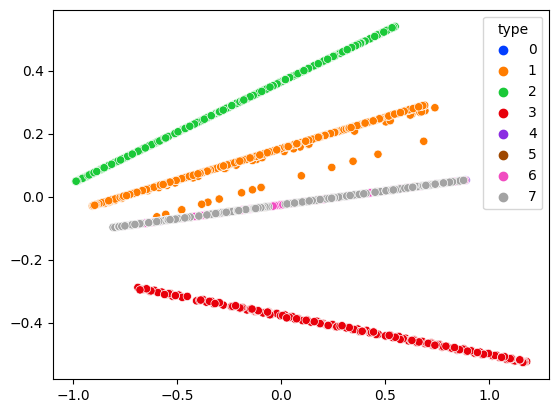

In [17]:
sns.scatterplot(x=pca_train[:,0], y=pca_train[:,1], hue=df_train['type'], palette='bright')

In [18]:
#7개의 변수 중 target으로 할 변수 선택(
target_axis = 0
models = []
thresholds = []

#각 type별로 독립적인 8개 모델 사용
for i in range(num_types):
    #target으로 결정한 column을 제외한 나머지 column들을 x_train으로 사용
    x_train = np.concatenate((train_data[df_train['type']==i][:,:target_axis],train_data[df_train['type']==i][:,target_axis+1:]), axis=1)
    #target column을 y_train으로 사용
    y_train = train_data[df_train['type'] == i][:,target_axis]
    
    #LinearRegression모델을 사용해 나머지 column들로 target column을 예측하는 task를 수행
    models.append(LinearRegression())
    models[i].fit(x_train, y_train)
    #Train data에서 target column 예측값 오차 중 최댓값을 해당 type의 threshold로 선정 (*1.5를 통해 좀 더 느슨하게 설정)
    thresholds.append(np.max(abs(models[i].predict(x_train) - y_train)) * 1.5)

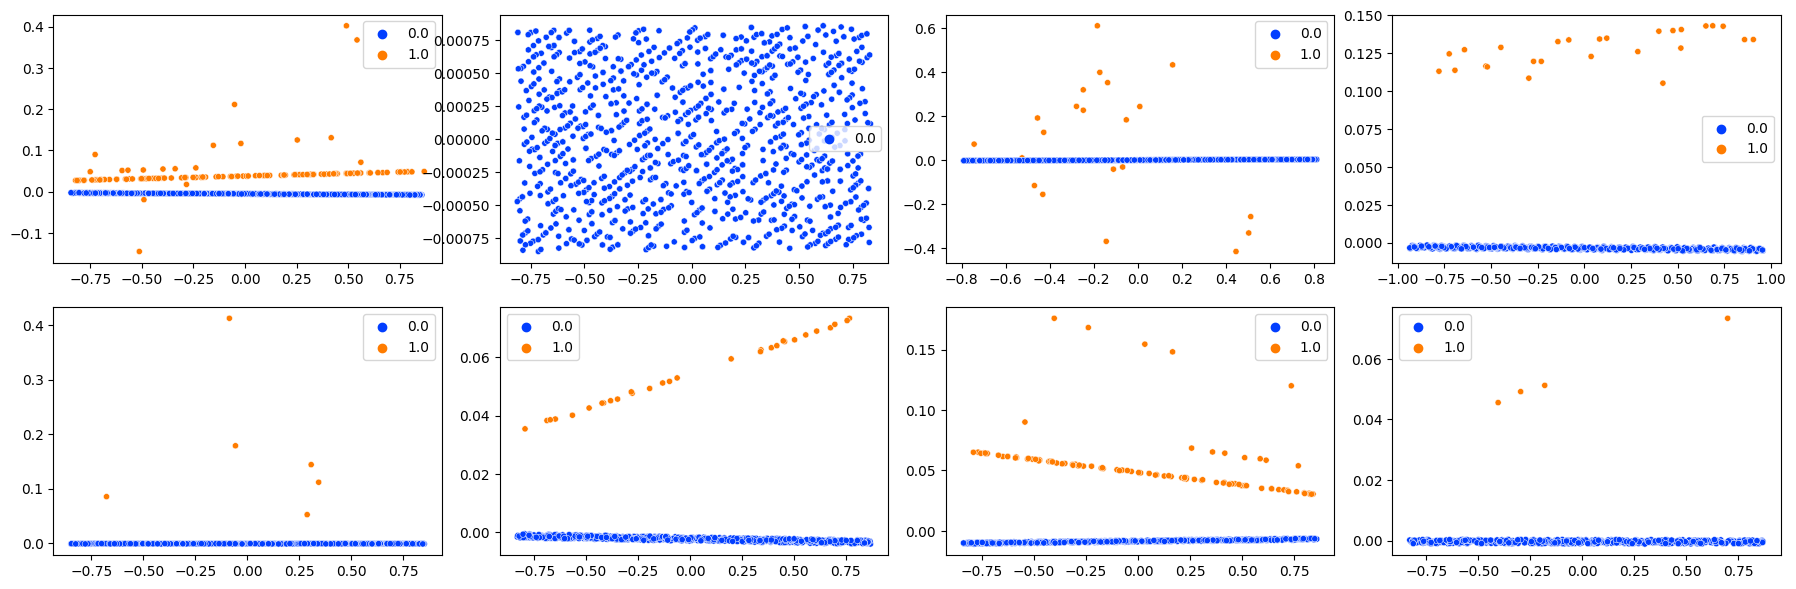

In [7]:
fig, axes = plt.subplots(2,4)
fig.set_size_inches(18,6)
fig.tight_layout()

preds = []
#각 type별로 독립적인 8개 모델 사용
for i in range(8):
    x = i // 4
    y = i % 4
    #target으로 결정한 column을 제외한 나머지 column들을 x_test로 사용
    x_test = np.concatenate((test_data[df_test['type']==i][:,:target_axis], test_data[df_test['type']==i][:,target_axis+1:]), axis=1)
    #target column을 y_test로 사용
    y_test = test_data[df_test['type'] == i][:,target_axis]
    pred = np.ones(len(x_test))
    
    
    test_err = abs(models[i].predict(x_test) - y_test)
    #Target값의 예측 오차가 threshold보다 크면 라벨 1할당.
    pred[(test_err < thresholds[i])] = 0
        
    pca_test = pca.fit_transform(test_data[df_test['type']==i])
    sns.scatterplot(x=pca_test[:,0], y=pca_test[:,1],hue=pred, ax=axes[x,y], palette='bright',s=20)
    
    preds.append(pred.copy())

In [9]:
preds = np.hstack(preds).astype(int)
submission['label'] = preds

In [10]:
submission['label'].value_counts()

0    7052
1     337
Name: label, dtype: int64

In [11]:
#Out_pressure가 0.7이 아닌 경우 수동으로 anomaly로 분류해줌
#(LinearRegression에서 out_pressure컬럼을 제거했기 때문에 정상치로 분류될 수 있음)

for i in range(len(df_test)):
    if df_test.iloc[i]['out_pressure'] != 0.7:
        submission.iloc[i,1] = 1

In [12]:
submission['label'].value_counts()

0    7045
1     344
Name: label, dtype: int64